In [18]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

import xgboost as xgb
from sklearn.metrics import r2_score
from bayes_opt import BayesianOptimization

from time import time
import csv
import pickle
from sklearn import model_selection
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from sklearn.ensemble import RandomForestClassifier

# Libraries to perform hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier
from xgboost import plot_importance  ## to plot feature importance

# Evaluation metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix

# To save the final model on disk
from sklearn.externals import joblib 

In [19]:
df_final_train = read_hdf('storage_sample_stage3-V3.h5', 'train_df',mode='r')

In [20]:
df_final_test = read_hdf('storage_sample_stage3-V3.h5', 'test_df',mode='r')

In [21]:
df_final_train.columns 

Index(['source', 'sink', 'edge_indecator', 'jaccard_followers',
       'jaccard_for_followees', 'cosine_followers', 'cosine_followees',
       'n_followers_source', 'n_followers_sink', 'n_followees_source',
       'n_followees_sink', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path',
       'prefential_for_followees', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d'],
      dtype='object')

In [56]:
df_final_train

,source,sink,edge_indecator,jaccard_followers,jaccard_for_followees,cosine_followers,cosine_followees,n_followers_source,n_followers_sink,n_followees_source,...,inter_followees,adar_index,follows_back,same_comp,shortest_path,prefential_for_followees,page_rank_s,page_rank_d,katz_s,katz_d
0,2401907,3562999,1,0.005102,0.000000,0,0,103,94,1141,...,0,0.000000,0,1,2,2,0.000765,0.000114,0.000765,0.000114
1,104316,307250,1,0.018692,0.002678,0,0,171,919,1108,...,98,46.718745,1,1,2,2,0.000746,0.020410,0.000746,0.020410
2,3189257,4519427,1,0.000000,0.000000,0,0,44,3,401,...,0,0.000000,0,1,3,3,0.000343,0.000114,0.000343,0.000114
3,1130724,889255,1,0.285714,0.028986,0,0,8,19,5,...,2,1.898633,1,1,2,2,0.000117,0.000152,0.000117,0.000152
4,1535773,696414,1,0.214953,0.000000,0,0,86,174,135,...,0,0.000000,0,1,2,2,0.000191,0.000114,0.000191,0.000114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101098,1704301,1890334,0,0.000000,0.000000,0,0,84,1,192,...,0,0.000000,0,1,4,4,0.000224,0.000114,0.000224,0.000114
101099,2809708,1936487,0,0.000000,0.000000,0,0,28,4,172,...,0,0.000000,0,1,3,3,0.000212,0.000114,0.000212,0.000114
101100,662696,4181269,0,0.142857,0.000000,0,0,6,2,72,...,0,0.000000,0,1,2,2,0.000155,0.000114,0.000155,0.000114
101101,1603868,4339146,0,0.000000,0.000000,0,0,7,2,41,...,0,0.000000,0,1,3,3,0.000138,0.000114,0.000138,0.000114


In [22]:
#target data for training data
y_train = df_final_train.edge_indecator

##  Feature Selection using Lasso Model

In [71]:
reg = LassoCV()
reg.fit(df_final_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(df_final_train,y_train))
coef = pd.Series(reg.coef_, index = df_final_train.columns)

Best alpha using built-in LassoCV: 5.807202
Best score using built-in LassoCV: 0.078706


In [72]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 5 variables and eliminated the other 13 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

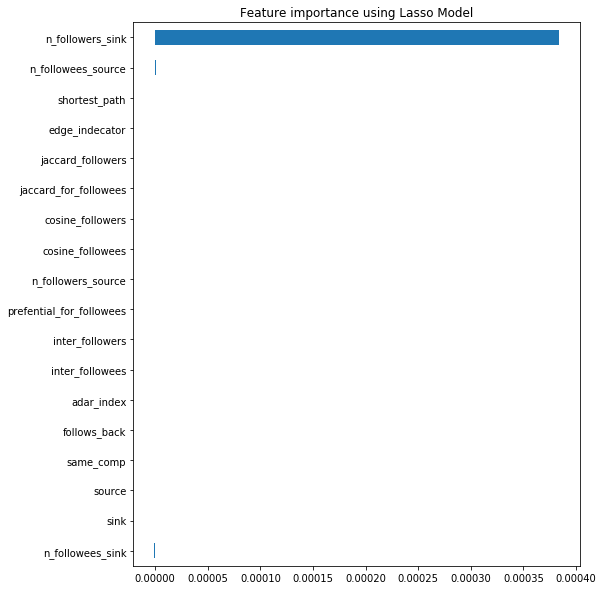

In [73]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [74]:
# #drop unwanted columns
# df_final_train.drop(['source', 'sink','edge_indecator','cosine_followers','cosine_followees','inter_followers','inter_followees',],axis=1,inplace=True)
# df_final_test.drop(['source', 'sink','cosine_followers','cosine_followees','inter_followers','inter_followees'],axis=1,inplace=True)

In [23]:
df_final_test


,source,sink,jaccard_followers,jaccard_for_followees,cosine_followers,cosine_followees,n_followers_source,n_followers_sink,n_followees_source,n_followees_sink,...,inter_followees,adar_index,follows_back,same_comp,shortest_path,prefential_for_followees,page_rank_s,page_rank_d,katz_s,katz_d
0,3563811,3600160,0.000000,0.0,0,0,3,29,21,0,...,0,0.0,0,1,4,4,0.000126,0.000114,0.000126,0.000114
1,2052043,1401960,0.000000,0.0,0,0,13,9,71,0,...,0,0.0,0,1,3,3,0.000155,0.000114,0.000155,0.000114
2,4517994,1690636,0.021053,0.0,0,0,80,17,205,0,...,0,0.0,0,1,2,2,0.000231,0.000114,0.000231,0.000114
3,1660006,4349447,0.030303,0.0,0,0,32,36,506,0,...,0,0.0,0,1,2,2,0.000403,0.000114,0.000403,0.000114
4,581111,1882617,0.000000,0.0,0,0,5,46,18,0,...,0,0.0,0,1,3,3,0.000124,0.000114,0.000124,0.000114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1461386,2341683,0.000000,0.0,0,0,16,2,53,0,...,0,0.0,0,1,3,3,0.000144,0.000114,0.000144,0.000114
1996,4057755,1871227,0.010753,0.0,0,0,53,41,95,0,...,0,0.0,0,1,3,3,0.000168,0.000114,0.000168,0.000114
1997,4242514,1413468,0.000000,0.0,0,0,6,2,26,0,...,0,0.0,0,1,3,3,0.000129,0.000114,0.000129,0.000114
1998,555531,1290080,0.000000,0.0,0,0,7,3,56,0,...,0,0.0,0,1,3,3,0.000146,0.000114,0.000146,0.000114


In [63]:
X = df_final_train[['prefential_for_followees','jaccard_followers','inter_followers','n_followees_source','katz_s','katz_d','page_rank_s','adar_index']]

In [64]:
X.columns

Index(['prefential_for_followees', 'jaccard_followers', 'inter_followers',
       'n_followees_source', 'katz_s', 'katz_d', 'page_rank_s', 'adar_index'],
      dtype='object')

In [65]:
test = df_final_test[['prefential_for_followees','jaccard_followers','inter_followers','n_followees_source','katz_s','katz_d','page_rank_s','adar_index']]

In [66]:
print(test.shape)

(2000, 8)


In [67]:
print(X.shape)

(101103, 8)


In [68]:
test

,prefential_for_followees,jaccard_followers,inter_followers,n_followees_source,katz_s,katz_d,page_rank_s,adar_index
0,4,0.000000,0,21,0.000126,0.000114,0.000126,0.0
1,3,0.000000,0,71,0.000155,0.000114,0.000155,0.0
2,2,0.021053,2,205,0.000231,0.000114,0.000231,0.0
3,2,0.030303,2,506,0.000403,0.000114,0.000403,0.0
4,3,0.000000,0,18,0.000124,0.000114,0.000124,0.0
...,...,...,...,...,...,...,...,...
1995,3,0.000000,0,53,0.000144,0.000114,0.000144,0.0
1996,3,0.010753,1,95,0.000168,0.000114,0.000168,0.0
1997,3,0.000000,0,26,0.000129,0.000114,0.000129,0.0
1998,3,0.000000,0,56,0.000146,0.000114,0.000146,0.0


# #Scaling

In [96]:
# Define R-Sqaured
def xgb_r2(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(preds, labels)
  
dtrain = xgb.DMatrix(df_final_train, y_train, feature_names=df_final_train.columns.values)

# Define Objective Function
def hyp_xgb(max_depth, subsample, colsample_bytree,min_child_weight, gamma ):
    params = {
    'n_estimators': 300,
    'eta': 0.05,
    'objective': 'reg:linear',
    'eval_metric':'mae', # Optional --> Use eval_metric if you want to stop evaluation based on eval_metric 
    'silent': 1
     }
    params['max_depth'] = int(round(max_depth))
    params['subsample'] = max(min(subsample, 1), 0)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['min_child_weight'] = int(min_child_weight)
    params['gamma'] = max(gamma, 0)
    scores = xgb.cv(params, dtrain, num_boost_round=1000,verbose_eval=False, early_stopping_rounds=10, feval=xgb_r2, maximize=True, nfold=5)
    return  scores['test-r2-mean'].iloc[-1]

In [97]:
pds ={
  'min_child_weight':(14, 20),
  'gamma':(0, 5),
  'subsample':(0.5, 1),
  'colsample_bytree':(0.1, 1),
  'max_depth': (5, 10)
}

In [98]:
# Surrogate model

optimizer = BayesianOptimization(hyp_xgb, pds, random_state=10)
                                  
# Optimize

optimizer.maximize(init_points=5, n_iter=15)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.9996   |  0.7942   |  0.1038   |  8.168    |  18.49    |  0.7493   |


KeyboardInterrupt: 

In [91]:


# monitor training performance
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.33, random_state=7)
# fit model no training data
model = XGBClassifier()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="error", eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

ValueError: Found input variables with inconsistent numbers of samples: [101103, 67739]

In [ ]:
start_time = time()
tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}
model = RandomizedSearchCV(XGBClassifier(), tuned_params, n_iter=15, scoring = 'roc_auc', n_jobs=-1)
model.fit(X,y_train) # actual data and actual prediction

print("--- %s seconds ---" % (time() - start_time))

In [ ]:
model.best_estimator_

In [101]:
start_time = time()
# tuned_params = {'max_depth': [4], 'learning_rate': [0.05], 'n_estimators': [500], 'reg_lambda': [1.0]}

clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=20,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=18, missing=None, n_estimators=700, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=25 ,reg_lambda=0, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)


print("--- %s seconds ---" % (time() - start_time))

--- 0.00010991096496582031 seconds ---


In [110]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y_train, test_size=0.30, random_state=42)
modelheld = clf.fit(X_train,Y_train)

In [111]:
result = modelheld.score(X_train,Y_train)
print("Accuracy: %.2f%%" % (result*100.0))

Accuracy: 86.68%


In [112]:
result = modelheld.score(X_test, Y_test)
print("Accuracy: %.2f%%" % (result*100.0))

Accuracy: 86.80%


In [113]:
pre=modelheld.predict_proba(X_test)
# print(pre)
y_pre=[p[1] for p in pre]
acc=modelheld.score(X_test,Y_test)
print(acc)
auc=roc_auc_score(Y_test,y_pre)
print(auc)

0.867989845372721
0.9224829612617963


No Skill: ROC AUC=0.500
MLP: ROC AUC=0.923


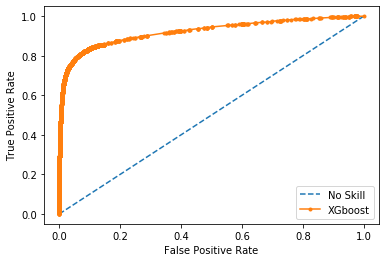

In [107]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(Y_test))]
# predict probabilities
mlp_probs = model_kfold.predict_proba(X_test)

# keep probabilities for the positive outcome only
mlp_probs = mlp_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)

mlp_auc=roc_auc_score(Y_test,mlp_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('MLP: ROC AUC=%.3f' % (mlp_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test,mlp_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='XGboost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [108]:
# this validation startegy improves the performance of the model and could be a better model validation strategy
kfold = model_selection.KFold(n_splits=10, random_state=None)
model_kfold = clf.fit(X,y_train) # fit XGboost model
results_kfold = model_selection.cross_val_score(model_kfold, X, y_train, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0))

Accuracy: 85.39%


In [ ]:
test

In [93]:
#x_testing = test.iloc[:,0:6].values
predictions=model_kfold.predict_proba(test)

In [114]:
result = model_kfold.score(X, y_train)
print("Accuracy: %.2f%%" % (result*100.0))

Accuracy: 86.72%


In [115]:
#convert the prediction to the csv file
with open("preXG-10.csv","w",newline="") as csvfile:
    writer=csv.writer(csvfile)
    writer.writerow(["Id","Predicted"])
    test_id=1
    for prediction in predictions:
        writer.writerow([test_id,prediction[1]])
        test_id+=1